In [80]:
import pandas as pd
import librosa  
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from tqdm import tqdm
import noisereduce as nr
from jupyterthemes import jtplot


In [5]:
jtplot.style(theme='monokai', context='notebook', ticks=True, gridlines='--')

# Bird data

In [39]:
rootFolder = "bird_data"
wavFolder = os.path.join("bird_data","wav_files")
wavFiles = os.listdir(wavFolder)
bird_calls_df = pd.read_csv(os.path.join(rootFolder, "bird_calls.csv"))
bird_calls_df.head()

,fname,label
0,American_Goldfinch_XC114342.wav,American_Goldfinch
1,American_Goldfinch_XC124312.wav,American_Goldfinch
2,American_Goldfinch_XC133564.wav,American_Goldfinch
3,American_Goldfinch_XC133565.wav,American_Goldfinch
4,American_Goldfinch_XC141469.wav,American_Goldfinch


# Class inbalance

In [40]:
bird_class_df = bird_calls_df.set_index('fname')
bird_class_df.head()

,label
fname,
American_Goldfinch_XC114342.wav,American_Goldfinch
American_Goldfinch_XC124312.wav,American_Goldfinch
American_Goldfinch_XC133564.wav,American_Goldfinch
American_Goldfinch_XC133565.wav,American_Goldfinch
American_Goldfinch_XC141469.wav,American_Goldfinch


In [41]:
# add column with the length of the signal in seconds
for f in bird_class_df.index:
    rate, signal = wavfile.read(os.path.join(wavFolder,f))
    bird_class_df.at[f, "length"] = signal.shape[0]/rate

bird_class_df.head()

,label,length
fname,,
American_Goldfinch_XC114342.wav,American_Goldfinch,136.968375
American_Goldfinch_XC124312.wav,American_Goldfinch,52.920000
American_Goldfinch_XC133564.wav,American_Goldfinch,50.599184
American_Goldfinch_XC133565.wav,American_Goldfinch,55.222857
American_Goldfinch_XC141469.wav,American_Goldfinch,54.058934


In [42]:
bird_classes = list(np.unique(bird_class_df.label))
bird_classes_distribution = bird_class_df.groupby(['label'])['length'].mean()
bird_classes_distribution

label
American_Goldfinch        52.322228
American_Robin            75.790837
Barn_Swallow             132.134248
Blue-grey_Gnatcatcher     60.431434
Blue_Jay                  49.986092
Carolina_Chickadee        56.634403
Carolina_Wren             50.195712
Cedar_Waxwing             39.937296
Northern_Cardinal         66.524785
Ruby-crowned_Kinglet      52.924116
Name: length, dtype: float64

### Plot class distribution


In [43]:
def hbarplot(data, xlabel, title):
    fig, ax = plt.subplots()
    ax.barh(data.index, data)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    plt.show()

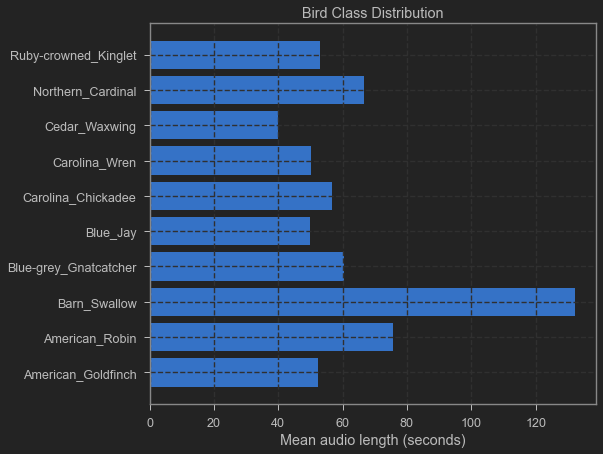

In [46]:
hbarplot(bird_classes_distribution, "Mean audio length (seconds)", "Bird Class Distribution")

# Feature Engineering
Feature 1: MFCC with cepstral filtering <br>
Feature 2: Mel-scaled spectrogram


## Load Audio Signal Function

In [7]:
# Load signal and apply noise reduction if required
def loadSignal(file, downsample=True, denoise=False):
    SR = (22050 if downsample else 44100)
    signal, sr = librosa.load(file, sr=SR, mono=True)
    if denoise:
        rsignal = nr.reduce_noise(audio_clip=signal, noise_clip=signal, verbose=False)
        return rsignal, sr
    else:
        return signal, sr

## Spectrogram Functions

In [55]:
# Plot mel-spectrogram
def Mel_Spectrogram(FILE, N_FFT, HOP_LENGTH, WINDOW, FILTER=False):
    FMIN = (1400 if FILTER else 0)
    signal, sr = loadSignal(FILE, True, True)  
    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, htk=True, window=WINDOW, fmin=FMIN, fmax=sr/2) 
    S_dB = librosa.power_to_db(mel**2,ref=np.max)
    return S_dB

In [56]:
# Mel-frequency cepstral coefficients (MFCCs)
def MFCC(FILE, N_FFT, N_MFCC, HOP_LENGTH, DCT=2, FILTER=False):
    LIFTER=(2*N_MFCC if FILTER else 0) # cesptral filtering
    signal, sr = loadSignal(FILE, True, True)  
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_fft = N_FFT, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, htk=True, lifter=LIFTER, dct_type=DCT)
    S_dB = librosa.power_to_db(mfccs**2,ref=np.max)
    return S_dB

In [57]:
mel_feature = {}
mfccs_feature = {}
for f in tqdm(wavFiles):
    wav_path=os.path.join(wavFolder, f)
    mel = Mel_Spectrogram(wav_path, 1024, 1024, 'hann', False)
    mel_feature[f]=mel
    mfccs = MFCC(wav_path, 1024, 40, 1024)
    mfccs_feature[f]=mfccs

In [108]:
mel_features_df = pd.DataFrame.from_dict(list(mel_feature.items()), orient='columns')
mel_features_df.rename(columns={0: "label", 1:"feature"}, inplace=True)
mel_df["label"]=mel_df["label"].str[:-13]
mel

In [122]:
def dict_to_csv(dictio, filepath):
    df = pd.DataFrame.from_dict(list(dictio.items()), orient='columns')
    col = {0: 'label', 1:'feature'}
    df.rename(columns=col, inplace=True)
    df.label = df.label.str[:-13]
    df.to_csv(filepath, index=False)

In [125]:
csv_name = ["mel_features.csv", "mfcc_features.csv"]
features = [mel_feature, mfccs_feature]
for n, f in zip(csv_name, features):
    path = os.path.join(rootFolder, n)
    dict_to_csv(f,path)